<a href="https://colab.research.google.com/github/yangshuxuan/traceanalyze/blob/master/clean_glitch_of_a_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 引言
模拟GPS采样，GPS定位本身有噪声，但是受制于环境等影响，有时噪声很大，即产生轨迹毛刺点。

# 引入需要用到的库

Next, import the libraries that we will use.

In [1]:
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



## 安装中文字体

In [43]:
!wget https://fonts.google.com/download?family=Noto%20Sans%20SC  -O Noto_Sans_SC.zip
!unzip -o Noto_Sans_SC.zip
!mv *.otf /usr/share/fonts/truetype/
path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
fontprop = fm.FontProperties(fname=path, size= 10)

--2020-07-10 04:06:31--  https://fonts.google.com/download?family=Noto%20Sans%20SC
Resolving fonts.google.com (fonts.google.com)... 172.217.203.113, 172.217.203.101, 172.217.203.100, ...
Connecting to fonts.google.com (fonts.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Noto_Sans_SC.zip’

Noto_Sans_SC.zip        [  <=>               ]  41.03M   114MB/s    in 0.4s    

2020-07-10 04:06:36 (114 MB/s) - ‘Noto_Sans_SC.zip’ saved [43025060]

Archive:  Noto_Sans_SC.zip
  inflating: OFL.txt                 
  inflating: NotoSansSC-Thin.otf     
  inflating: NotoSansSC-Light.otf    
  inflating: NotoSansSC-Regular.otf  
  inflating: NotoSansSC-Medium.otf   
  inflating: NotoSansSC-Bold.otf     
  inflating: NotoSansSC-Black.otf    


### 测试中文字体是否管用

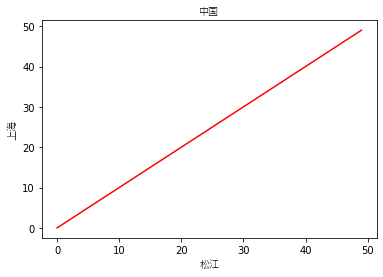

In [3]:
plt.plot(range(50), range(50), 'r')
plt.title('中国', fontproperties=fontprop)
plt.ylabel('上海', fontproperties=fontprop)
plt.xlabel('松江', fontproperties=fontprop)
plt.show()

# 设置随机种子
结果可重现

In [4]:
np.random.seed(0)

# 生成正常的轨迹点间隔值
这里假设飞机以800Km/h的速度巡航，每分钟定位一次，因此每分钟的纬度和经度的各自增加大概为0.1。

In [5]:
normalMu, normalSigma = 0.1, 0.1 # 经纬度增量平均值和标准方差
normalSampleNum = 500 #样本数
normalIntervalSample = np.random.normal(normalMu, normalSigma, (normalSampleNum,2)) #同时生成经度和纬度的增量，因此是2

# 设置轨迹起点
纬度在前，经度在后

In [6]:
startPoint=[31.23, 121.47] #此处是China ShangHai

# 生成正常轨迹
此处沿axix=0累加，然后都加上起点的经纬度

In [7]:
normalSample = normalIntervalSample.cumsum(0) + np.array(startPoint).reshape((1,2))

# 生成异常轨迹点间隔值
类似于正常轨迹点间隔值的生成，但是方差较大，并且需要指定毛刺点的占比。

In [8]:
abnormalMu, abnormalSigma = 0.1, 10.0 # mean and standard deviation
abnormalSamplePercent = 0.01 #毛刺点在总体的占比
abnormalSampleNum = int(normalSampleNum *  abnormalSamplePercent)
abnormalIntervalSample = np.random.normal(abnormalMu, abnormalSigma, (abnormalSampleNum,2))

# 选择需要替换为毛刺点的正常轨迹的索引

In [9]:
normalSampleIndexArr = np.arange(1,normalSampleNum) #默认起点不是毛刺点，因此从1开始采样
np.random.shuffle(normalSampleIndexArr) #随机打乱


# 将部分正常点替换为毛刺点

In [10]:
normalSample[normalSampleIndexArr[0:abnormalSampleNum]] = normalSample[normalSampleIndexArr[0:abnormalSampleNum]-1]+abnormalIntervalSample

# 转成DataFrame并画图展示

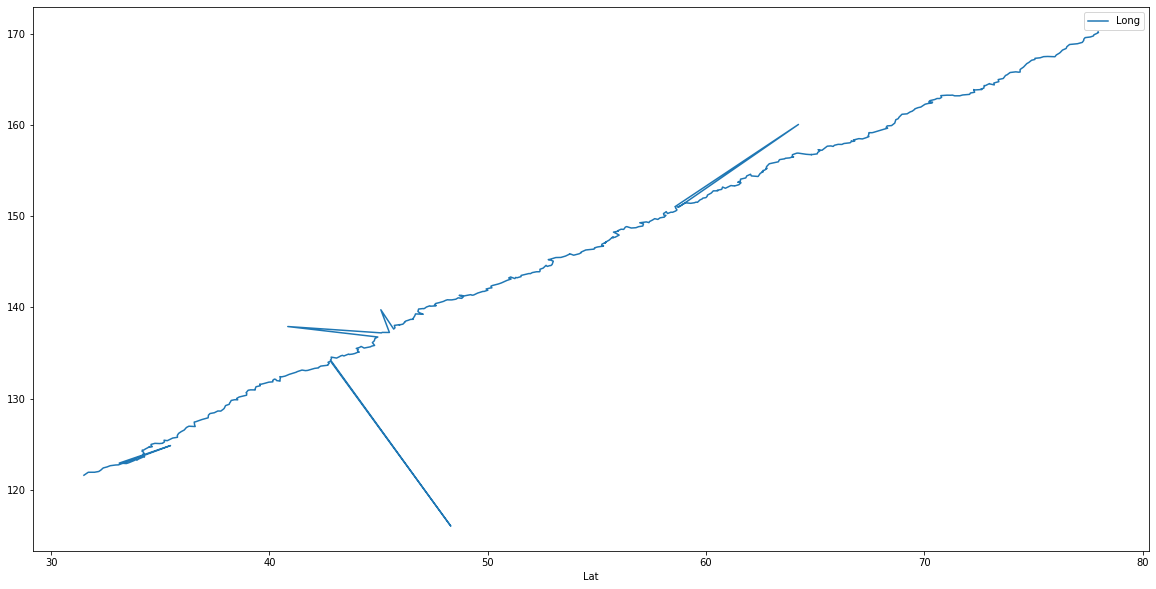

In [11]:
df = pd.DataFrame(normalSample,columns=['Lat', 'Long'])
df.plot.line(x = 'Lat', y = 'Long',figsize=(20,10))

# DBScan清理毛刺
DBScan可以对任意形状进行聚类，因此可以尝试用来清理毛刺，因为毛刺可以认为是离群点，因此这个问题就变成清理离群点。

## 地球半径以千米为单位

In [12]:
kms_per_rad = 6371.0088

## 设置样本数
假设飞机以800公里/小时飞行，每分钟定位一次，那么差不多每分钟飞行14公里，那么每个点前后30公里范围内大概有5个点（包括自身），那么可以认为有3个点可以证明这不是离群点。

In [13]:
eps = 40 
epsilon = eps/kms_per_rad #变成弧度，因为后面DBScan算法将会使用弧度来cluster
min_sample=3

## 使用DBSCan算法聚类
metric使用haversine，可以参考[scikit](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html?highlight=haversine#sklearn.metrics.pairwise.haversine_distances)
计算之前也需要将角度变成弧度，同时纬度在前，经度在后。

In [38]:
fac_coords = normalSample
dbsc = cluster.DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(fac_coords))
y_pred = dbsc.labels_

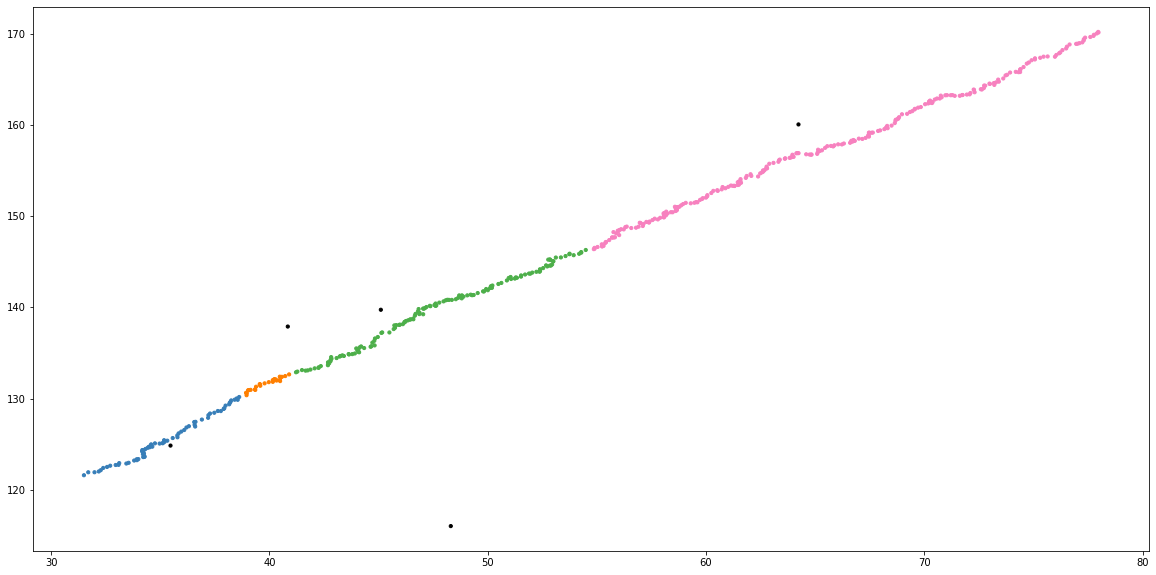

In [39]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.figure(figsize=(20,10))
plt.scatter(fac_coords[:, 0],fac_coords[:, 1], s=10, color=colors[y_pred])

清理毛刺，离群点的label一般为-1

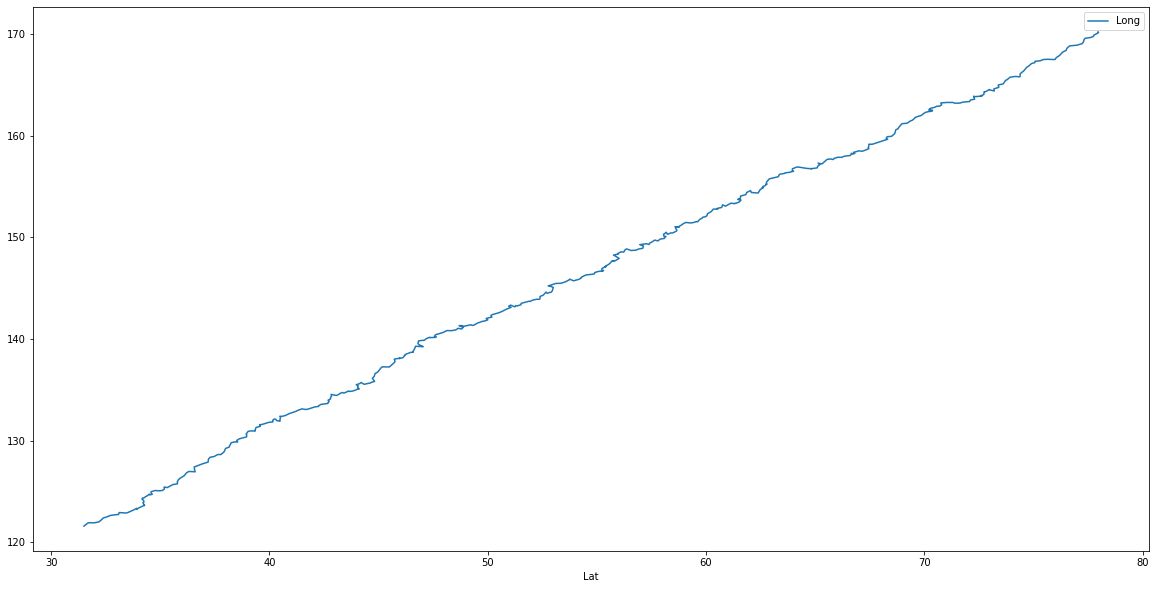

In [41]:
afterCleanGlitch = normalSample[y_pred != -1]
pd.DataFrame(afterCleanGlitch,columns=['Lat', 'Long']).plot.line(x = 'Lat', y = 'Long',figsize=(20,10))

### 分析
如上面两个图所示，尽管有多个cluster，但还是把离群点即毛刺清理掉了

### 结论
这个方法很容易使用，但是忽略了时间因素，如果毛刺点恰好混入到先前的轨迹点中，这个毛刺就不太容易清理了。

## 比较不同参数设置时的毛刺处理效果

### 设置参数列表

In [16]:
epses = np.arange(30,100,10)/kms_per_rad 

min_samples= np.arange(2,10,2)

numepses = len(epses)
nummin_samples = len(min_samples)

In [34]:
def drawEachPicture(epse,min_sample,fac_coords,indexi,indexj,axs):
  path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
  fontprop = fm.FontProperties(fname=path, size= 15)
  dbsc = cluster.DBSCAN(eps=epse, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(fac_coords))
  y_pred = dbsc.labels_
  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])

  curPlot = axs[indexi,indexj]
  if indexi == 0:
    curPlot.set_title("最少样本数%d"%(min_sample,),fontproperties=fontprop)
  curPlot.text(.99, .01, ('半径%.0f千米' % (epse * kms_per_rad)).lstrip('0'), size=15,horizontalalignment='right',transform=curPlot.transAxes,fontproperties=fontprop)
  curPlot.set_ylabel('经度', fontproperties=fontprop)
  curPlot.set_xlabel('纬度', fontproperties=fontprop)
  curPlot.scatter(fac_coords[:, 0],fac_coords[:, 1], s=10, color=colors[y_pred])
  

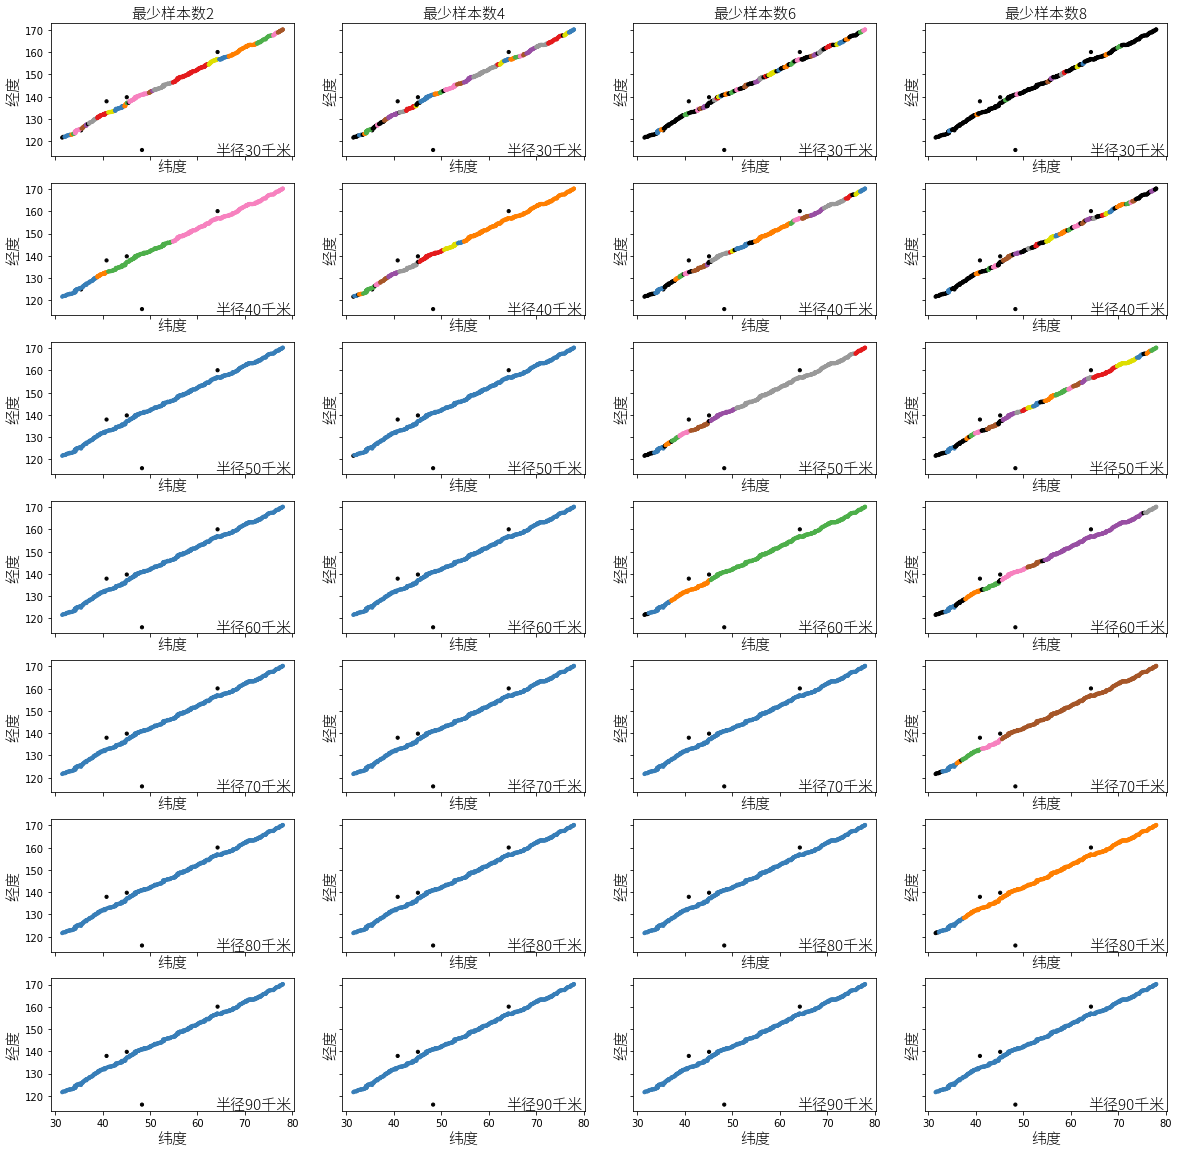

In [35]:
f, axs = plt.subplots(numepses,nummin_samples,figsize=(20,20), sharex=True, sharey=True)
for indexi,i in  enumerate(epses):
  for indexj,j in enumerate(min_samples):
    drawEachPicture(i,j,normalSample,indexi,indexj,axs)

  

### 结论
如果半径小而且样本数要求多的情况下，基本无法识别真正的离群点。

In [ ]:
axs

# Optics清理毛刺